In [1]:
#! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d paultimothymooney/kermany2018

100% 10.8G/10.8G [03:52<00:00, 35.1MB/s]
100% 10.8G/10.8G [03:52<00:00, 50.1MB/s]


In [3]:
!unzip /content/kermany2018.zip

Streaming output truncated to the last 5000 lines.
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8050636-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-4.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-5.jpeg  
  inflating: 

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL.Image import fromarray

# Sources

<div style = "text-align: justify">The OCT images were obtained from retrospective cohorts of adult patients from Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center for Ophthalmology Associates, the Shanghai First People's Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.</div>

In [5]:
paths = ['/content/OCT2017 /train',
         '/content/OCT2017 /test',
         '/content/OCT2017 /val']

In [6]:
import os
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import img_to_array

In [7]:
def cvt_arr (impath) :
    return 
                        
def get_array (path) :
    
    X = []
    y = []
    
    for label, disease in enumerate(os.listdir(path)) :
        
        
        
        
        # resize and append
        for count, image in enumerate(os.listdir(os.path.join(path, disease))) :
            X.append(img_to_array(
                fromarray(
                    cv2.resize(
                        cv2.imread(
                            os.path.join(os.path.join(path, disease),image)),(128,128)))))
            
            # only 5k imgs
            y.append(label)
            if count > 5e3 :
                break
    
    X = np.array(X)
    y = np.array(y)
    
    return X/255.0, to_categorical(y)

In [8]:
X_train, y_train = get_array(paths[0])
print('training data extracted .....')
X_test , y_test  = get_array(paths[1])
print('testing data extracted ......')
X_valid, y_valid = get_array(paths[2])
print('validation data extracted ...')

training data extracted .....
testing data extracted ......
validation data extracted ...


In [9]:
print(X_train.shape)
print(y_train.shape)

(20008, 128, 128, 3)
(20008, 4)


In [10]:
print(X_test.shape)
print(y_test.shape)

(968, 128, 128, 3)
(968, 4)


In [11]:
print(X_valid.shape)
print(y_valid.shape)

(32, 128, 128, 3)
(32, 4)


In [12]:
print(X_train.min())
print(X_train.max())

0.0
1.0


In [13]:
print(y_train.min())
print(y_train.max())

0.0
1.0


# Image visualization & class distribution

In [14]:
info = {
    0 : 'DRUSEN',
    1 : 'CNV',
    2 : 'NORMAL',
    3 : 'DME',
}

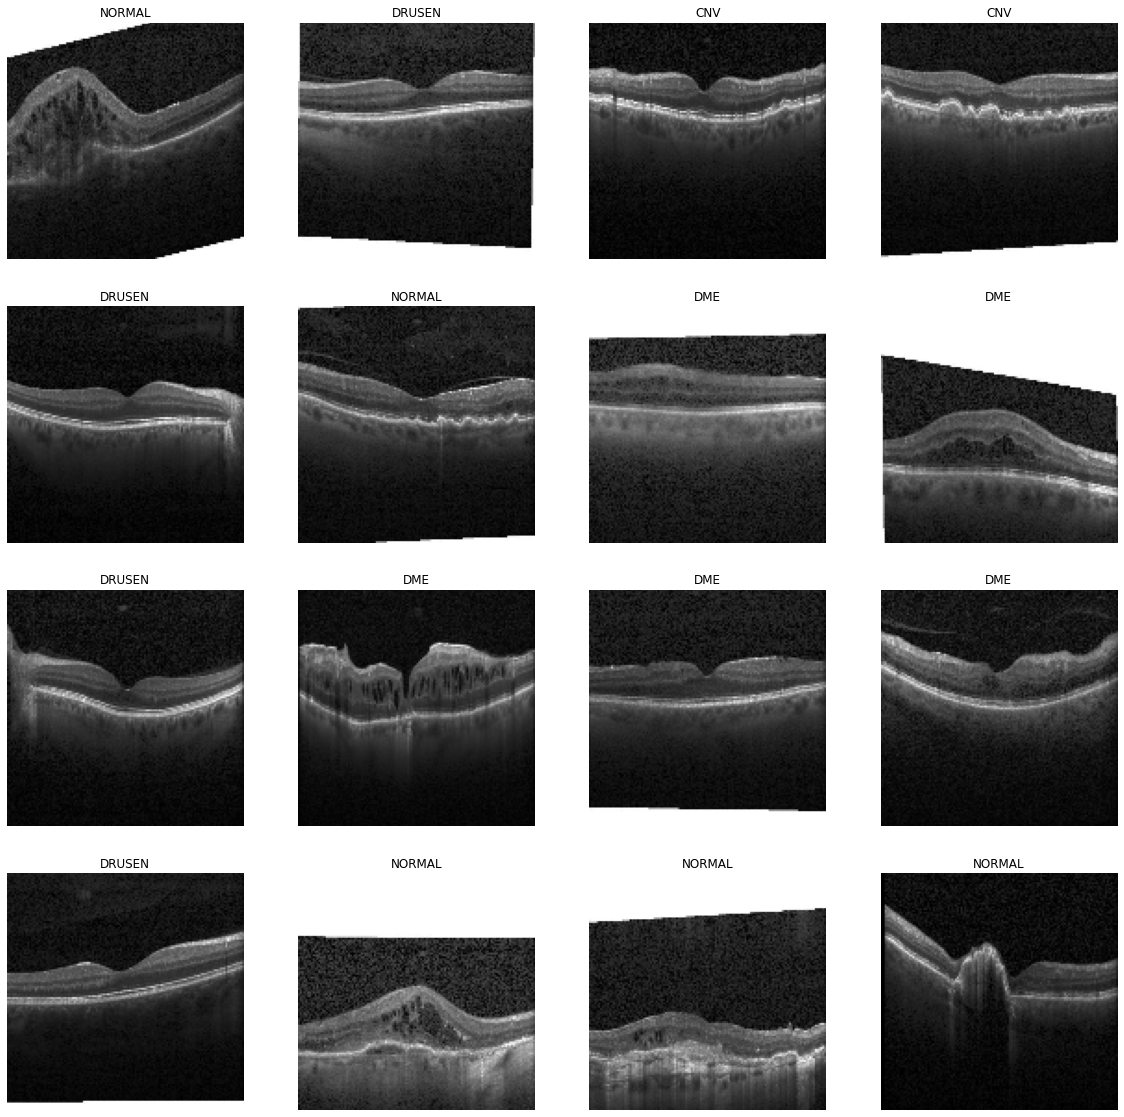

In [15]:
plt.figure(figsize = (20,20))

i = 0

while i < 16 :
    
    x = np.random.randint(0, 20000)
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[x])
    plt.axis('off')
    plt.title(info[np.argmax(y_train[x])])
    
    i += 1
plt.show()

In [16]:
import seaborn
import pandas

Training data distribution

Text(0.5, 1.0, 'Test label distribution')

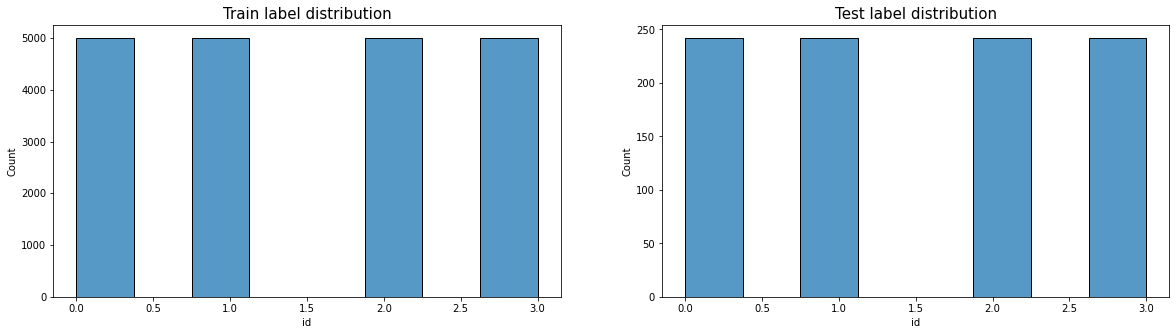

In [17]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
seaborn.histplot(data = pandas.DataFrame({'id' : np.argmax(y_train, axis = 1)}), x = 'id', bins = 8)
plt.title('Train label distribution', fontsize = 15)

plt.subplot(1,2,2)
seaborn.histplot(data = pandas.DataFrame({'id' : np.argmax(y_test , axis = 1)}), x = 'id', bins = 8)
plt.title('Test label distribution', fontsize = 15)

# Image Augmentation

#### *Augment using ImageDataGenerator() with rotation by 15 deg, horizontal flips, height shift and zoom in by 20%.*

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
train_gen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, height_shift_range = [-5,5], zoom_range = [0.80, 1.00])

In [20]:
train_gen.fit(X_train)

In [21]:
point = train_gen.flow(X_train, y_train)

In [22]:
trainX, trainy = point.next()

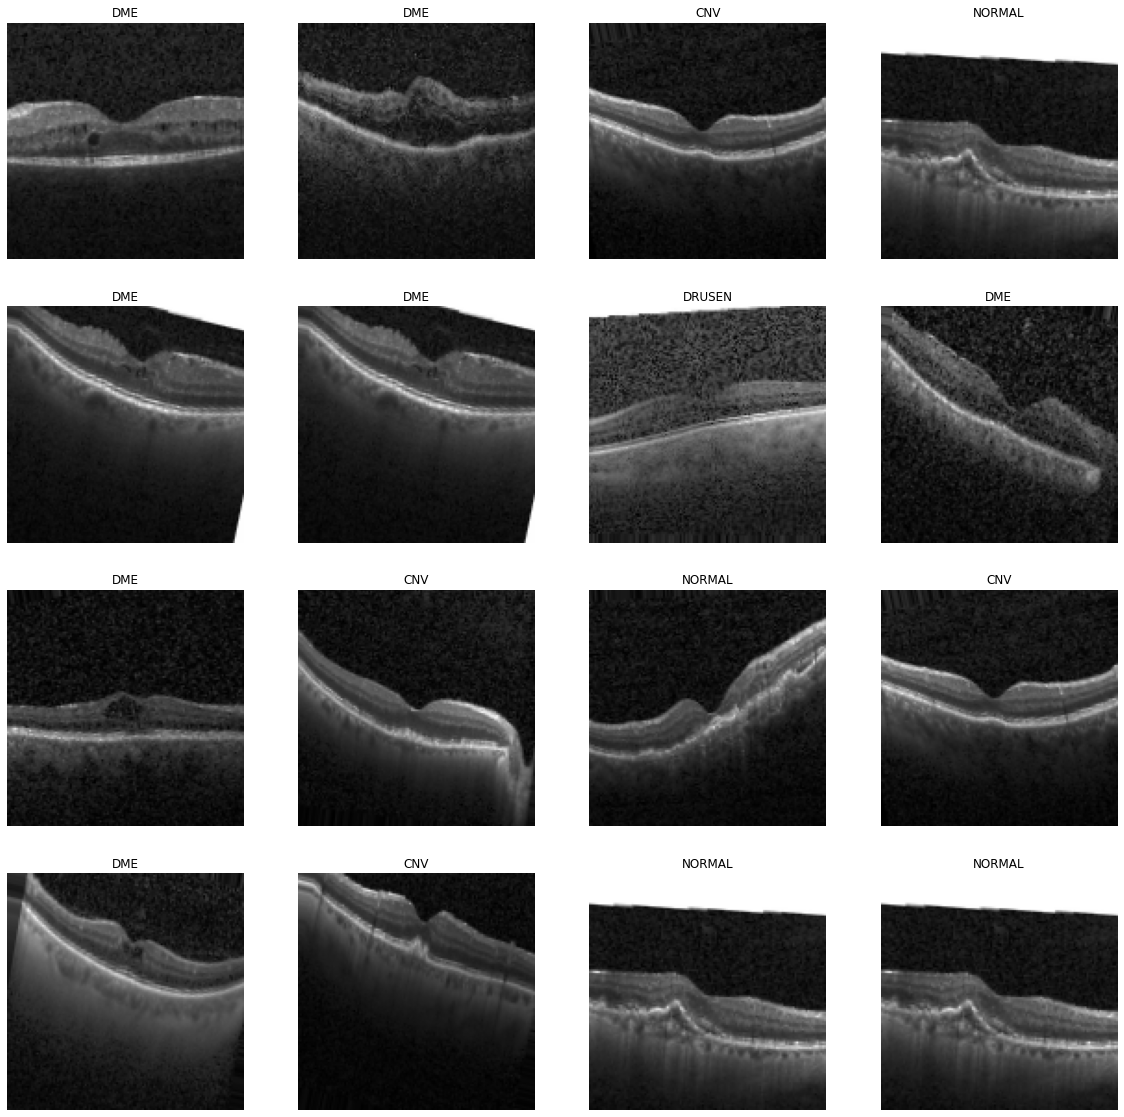

In [23]:
plt.figure(figsize = (20,20))

i = 0

while i < 16 :
    
    x = np.random.randint(0, 32)
    plt.subplot(4, 4,i+1)
    plt.imshow(trainX[x])
    plt.axis('off')
    plt.title(info[np.argmax(trainy[x])])
    
    i += 1
plt.show()

# Model Architecture

In [24]:
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization

In [25]:
def conv_layer (filterx) :
    
    model = Sequential()
    
    model.add(Conv2D(filterx, (4,4), padding = 'same', use_bias = False))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    model.add(MaxPooling2D((2, 2)))
    
    return model

def dens_layer (hiddenx) :
    
    model = Sequential()
    
    model.add(Dense(hiddenx, kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(LeakyReLU())
    
    return model

In [26]:
def cnn (filter1, filter2, filter3, hidden1) :
    
    model = Sequential([
        
        Input((128,128,3,)),
        conv_layer(filter1),
        conv_layer(filter2),
        conv_layer(filter3),
        Flatten(),
        dens_layer(hidden1),
        Dense(4, activation = 'softmax')
    ])
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [27]:
model = cnn(16, 32, 64, 120)

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 16)        832       
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 32)        8320      
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 16, 64)        33024     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 120)               1966680   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 484       
Total params: 2,009,340
Trainable params: 2,008,876
Non-trainable params: 464
__________________________________________

In [29]:
import tensorflow as tf

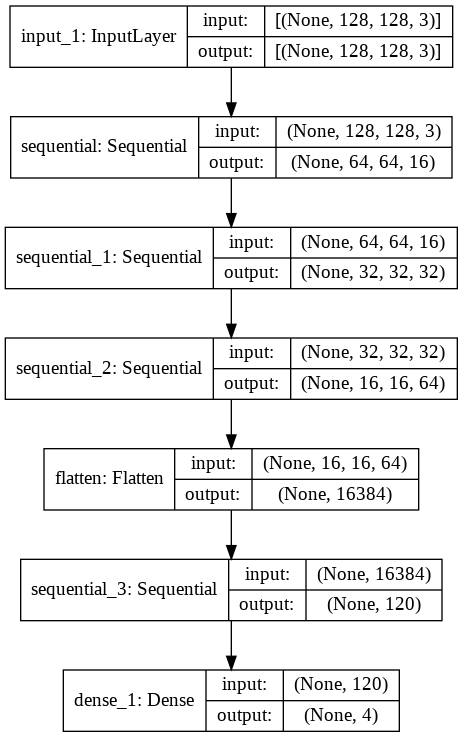

In [30]:
tf.keras.utils.plot_model(model, './ret_model.png', show_shapes = True)

# fit() Change Drive Path

In [31]:
checkp = tf.keras.callbacks.ModelCheckpoint('./ret_model.h5', monitor = 'val_loss', save_best_only = True, verbose = 1)

In [34]:
history = model.fit(train_gen.flow(X_train, y_train, batch_size = 64), epochs = 5, validation_data = (X_valid, y_valid), callbacks = [checkp])

model.save('/content/drive/MyDrive/retinal-oct-image-classification.h5')

Epoch 1/5
313/313 [==============================] - 86s 274ms/step - loss: 1.7505 - accuracy: 0.5287 - val_loss: 1.7550 - val_accuracy: 0.4688

Epoch 00001: val_loss improved from inf to 1.75499, saving model to ./ret_model.h5
Epoch 2/5
313/313 [==============================] - 85s 273ms/step - loss: 1.0524 - accuracy: 0.6721 - val_loss: 1.3901 - val_accuracy: 0.4375

Epoch 00002: val_loss improved from 1.75499 to 1.39010, saving model to ./ret_model.h5
Epoch 3/5
313/313 [==============================] - 85s 270ms/step - loss: 0.9317 - accuracy: 0.7260 - val_loss: 1.3808 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 1.39010 to 1.38078, saving model to ./ret_model.h5
Epoch 4/5
313/313 [==============================] - 85s 271ms/step - loss: 0.8571 - accuracy: 0.7616 - val_loss: 1.1084 - val_accuracy: 0.6562

Epoch 00004: val_loss improved from 1.38078 to 1.10838, saving model to ./ret_model.h5
Epoch 5/5
313/313 [==============================] - 85s 271ms/step - loss: 

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loss and accuracy progression

Text(0, 0.5, 'Losses')

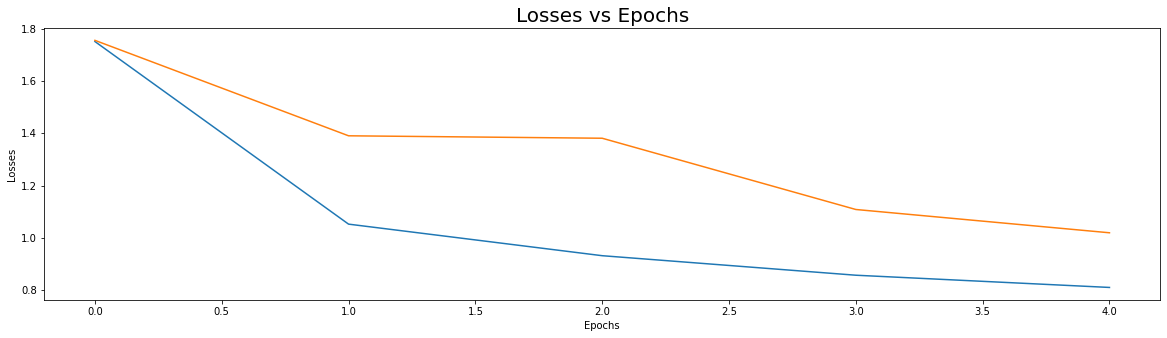

In [35]:
plt.figure(figsize = (20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Losses vs Epochs', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Losses')

Text(0, 0.5, 'Accuracy')

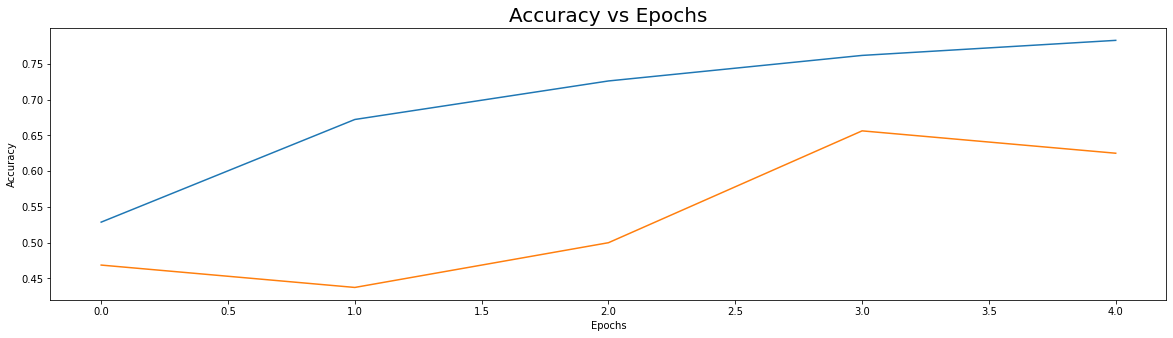

In [36]:
plt.figure(figsize = (20,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs', fontsize = 20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Prediction

In [37]:
model = tf.keras.models.load_model('./ret_model.h5')

In [38]:
y_pred = model.predict(X_test)

In [39]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [41]:
label = ['DRUSEN', 'CNV', 'NORMAL', 'DME']

In [42]:
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = label))

Accuracy : 0.6105371900826446
              precision    recall  f1-score   support

      DRUSEN       0.74      0.98      0.84       242
         CNV       0.93      0.29      0.44       242
      NORMAL       0.46      1.00      0.63       242
         DME       1.00      0.18      0.30       242

    accuracy                           0.61       968
   macro avg       0.78      0.61      0.55       968
weighted avg       0.78      0.61      0.55       968



# Confusion Matrix

In [43]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 145.31999999999996, 'Predicted')

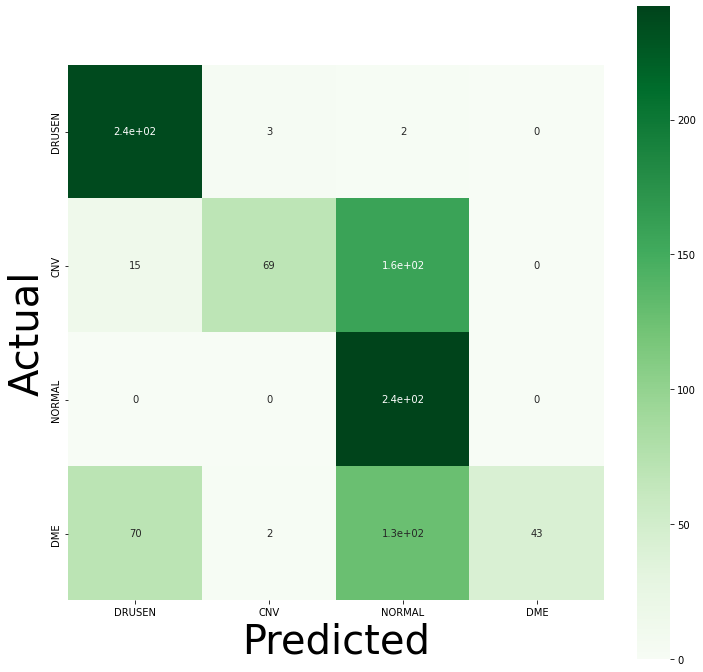

In [44]:
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)